In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.0 MB/s eta 0:00:00


In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0895194d272a459b39fe61180d06aa5f252902e563994b9cea720bd853379009
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.8 MB/s eta 0:00:00


In [ ]:
#!pip install catboost

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Multiply
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, concatenate, Permute
from tensorflow.keras.layers import Activation, TimeDistributed, GlobalAveragePooling1D, RepeatVector
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.mixed_precision import Policy, set_global_policy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from ta.volatility import BollingerBands, AverageTrueRange, KeltnerChannel, DonchianChannel
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import SMAIndicator, MACD, ADXIndicator, IchimokuIndicator
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator
#from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import backtrader as bt
import streamlit as st
import random

In [ ]:
import torch
# Если GPU доступны, то в качестве рабочего устройства используется cuda иначе cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
if (device == "cuda"):
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))

Using cpu device


In [ ]:
def configure_gpu():
    """Настраивает GPU окружение для максимальной производительности"""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Включаем mixed precision (новый API)
            policy = Policy('mixed_float16')
            set_global_policy(policy)

            # Разрешаем рост памяти GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            # Логирование информации
            print(f"Активировано {len(gpus)} GPU:")
            for i, gpu in enumerate(gpus):
                print(f"[GPU {i}] {gpu.name}")
                # Дополнительные настройки для каждого GPU
                tf.config.experimental.set_virtual_device_configuration(
                    gpu,
                    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*8)]  # 8GB
                )
            return len(gpus)
        except RuntimeError as e:
            print(f"Ошибка конфигурации GPU: {e}")
    return 0

In [ ]:
def seed_everything_tf(seed: int = 42) -> None:
    #os.environ['PYTHONHASHSEED'] = str(seed)
    #torch.manual_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Using {seed} seed")
seed_everything_tf(42)

Using 42 seed


In [ ]:
# Загрузка данных из файла
def load_data_from_file(file_path):
  try:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data
  except FileNotFoundError:
      print(f"Файл '{file_path}' не найден.")
      return None

# Загрузка данных из yaho finance
def load_data_from_yf(ticker, timeframe='1d'):
  df = yf.download(ticker, interval=timeframe)
  df = df.reset_index()
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = df.columns.droplevel(level=1)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  return df

In [ ]:
# Индикатор RSI
def rsi(close_prices, n=14):
  delta = close_prices.diff().dropna()
  up = delta.clip(lower=0)
  down = -delta.clip(upper=0)
  rs = up.ewm(span=n, adjust=False).mean() / down.ewm(span=n, adjust=False).mean()
  return 100 - (100 / (1 + rs))

In [ ]:
# Индикатор Chaikin Money Flow (CMF)
def add_chaikin_money_flow(data, window=20):
    cmf_indicator = ChaikinMoneyFlowIndicator(
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        volume=data['Volume'],
        window=window
    )
    data['CMF'] = cmf_indicator.chaikin_money_flow()
    return data

In [ ]:
# Индикатор Keltner Channels
def add_keltner_channels(data, window=20, window_atr=10):
    keltner = KeltnerChannel(
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        window=window,
        window_atr=window_atr
    )
    data['Keltner_High'] = keltner.keltner_channel_hband()
    data['Keltner_Low'] = keltner.keltner_channel_lband()
    data['Keltner_Width'] = keltner.keltner_channel_wband()
    return data

In [ ]:
# Индикатор Ichimoku Clouds
def add_ichimoku_clouds(data, conversion_window=9, base_window=26, lagging_window=52):
    ichimoku = IchimokuIndicator(
        high=data['High'],
        low=data['Low'],
        window1=conversion_window, # Параметр для Conversion Line
        window2=base_window,       # Параметр для Base Line
        window3=lagging_window     # Параметр для Lagging Span
    )
    data['Ichimoku_Conversion_Line'] = ichimoku.ichimoku_conversion_line()
    data['Ichimoku_Base_Line'] = ichimoku.ichimoku_base_line()
    data['Ichimoku_Span_A'] = ichimoku.ichimoku_a()
    data['Ichimoku_Span_B'] = ichimoku.ichimoku_b()
    return data

In [ ]:
# Индикатор Donchian Channels
def add_donchian_channels(data, window=20):
    donchian = DonchianChannel(
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        window=window
    )
    data['Donchian_High'] = donchian.donchian_channel_hband()
    data['Donchian_Low'] = donchian.donchian_channel_lband()
    data['Donchian_Width'] = donchian.donchian_channel_wband()
    return data

In [ ]:
# Колонки для нормализации
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mean', 'Value',
                    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'MACD_1', 'Signal_Line_1', 'MACD_2', 'Signal_Line_2',
                    'ATR_14', 'ATR_21', 'BB_high', 'BB_low', 'BB_width', 'OBV',
                    'Keltner_High', 'Keltner_Low', 'Keltner_Width',
                    'Ichimoku_Conversion_Line','Ichimoku_Base_Line','Ichimoku_Span_A','Ichimoku_Span_B',
                    'Donchian_High','Donchian_Low','Donchian_Width']
# Колонки, которые не нужно нормализовать
columns_not_to_scale = ['RSI_14', 'RSI_28', 'SO', 'SO_signal', 'ADX', 'DI+', 'DI-', 'WR', 'CMF']

# Предобработка данных
def preprocess_data(data, window_size=30):
  # Добавление новых признаков
  data['Mean'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4  # Средняя цена
  data['Value'] = data['Volume'] * data['Mean']  # Объём в деньгах

  # Скользящие средние разных периодов
  for window in [5, 10, 20, 50]:
    sma = SMAIndicator(close=data['Close'], window=window)
    data[f'SMA_{window}'] = sma.sma_indicator()

  # MACD с разными настройками
  macd1 = MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
  data['MACD_1'] = macd1.macd()
  data['Signal_Line_1'] = macd1.macd_signal()

  macd2 = MACD(close=data['Close'], window_slow=19, window_fast=8, window_sign=9)
  data['MACD_2'] = macd2.macd()
  data['Signal_Line_2'] = macd2.macd_signal()

  # ATR с разными периодами
  for window in [14, 21]:
    atr = AverageTrueRange(high=data['High'], low=data['Low'],
                          close=data['Close'], window=window)
    data[f'ATR_{window}'] = atr.average_true_range()

  # Bollinger Bands
  bb_indicator = BollingerBands(close=data['Close'], window=20, window_dev=2)
  data['BB_high'] = bb_indicator.bollinger_hband()
  data['BB_low'] = bb_indicator.bollinger_lband()
  data['BB_width'] = bb_indicator.bollinger_wband()

  # RSI с разными периодами
  for window in [14, 28]:
    rsi = RSIIndicator(close=data['Close'], window=window)
    data[f'RSI_{window}'] = rsi.rsi()

  # Stochastic Oscillator
  so_indicator = StochasticOscillator(high=data['High'], low=data['Low'], close=data['Close'], window=14, smooth_window=3)
  data['SO'] = so_indicator.stoch()
  data['SO_signal'] = so_indicator.stoch_signal()

  # ADX
  adx = ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
  data['ADX'] = adx.adx()
  data['DI+'] = adx.adx_pos()
  data['DI-'] = adx.adx_neg()

  # Объемные индикаторы
  data['OBV'] = OnBalanceVolumeIndicator(close=data['Close'], volume=data['Volume']).on_balance_volume()

  #  Williams Indicator
  wr_indicator = WilliamsRIndicator(high=data['High'], low=data['Low'], close=data['Close'], lbp=14)
  data['WR'] = wr_indicator.williams_r()

  # Chaikin Money Flow (CMF)
  data = add_chaikin_money_flow(data)

  # Keltner Channels
  data = add_keltner_channels(data)

  # Ichimoku Clouds
  data = add_ichimoku_clouds(data)

  # Donchian Channels
  data = add_donchian_channels(data)

  # Формирование признака предсказания для стратегии, основанной на использовании GAP,
  # как отношения цены открытия завтра к цене закрытия сегодня
  data["Predict"] = data['Open'].shift(-1) / data["Close"]
  #data["Predict"] = data['Close'].shift(-1) / data["Close"]

  # Удаляем строки с NaN-значениями
  data.dropna(inplace=True)

  # Сохраняем реальные цены закрытия
  Close_prices = data['Close'].values

  # Сохраняем колонку 'Predict' для целевой переменной
  y_data = data['Predict'].values

  # Удаление колонки 'Predict' и преобразование DataFrame в массив NumPy для удобства работы
  X_data = data.drop(columns=['Predict']).values

  # Проверка наличия всех колонок в данных
  missing_columns = [col for col in columns_to_scale + columns_not_to_scale if col not in data.columns]
  if missing_columns:
      raise ValueError(f"В данных отсутствуют следующие колонки: {missing_columns}")

  # Индексы колонок для масштабирования и не для масштабирования
  columns_to_scale_indices = [data.columns.get_loc(col) for col in columns_to_scale]
  columns_not_to_scale_indices = [data.columns.get_loc(col) for col in columns_not_to_scale]

  # Нормализация данных только к выбранным колонкам
  #scaler = MinMaxScaler(feature_range=(0, 1))  # Можно использовать другой скейлер

  # Создание временных окон
  X, y = [], []
  for i in range(window_size, len(data)):
    # Выбираем окно данных
    window = X_data[i - window_size:i, :]

    # Разделяем данные на те, которые нужно масштабировать, и те, которые не нужно
    window_to_scale = window[:, columns_to_scale_indices]
    window_not_to_scale = window[:, columns_not_to_scale_indices]

    # Масштабируем только нужные колонки
    # Для каждой колонки делим элементы на среднее значение в окне
    #scaled_window_to_scale = window_to_scale / np.mean(window_to_scale, axis=0, keepdims=True)

    # Масштабируем только нужные колонки
    # Для каждой колонки применяем MinMaxScaler независимо
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_window_to_scale = scaler.fit_transform(window_to_scale)

    # Объединяем масштабированные и немасштабированные данные
    scaled_window = np.hstack((scaled_window_to_scale, window_not_to_scale))

    # Добавляем масштабированное окно в X
    X.append(scaled_window)

    # Добавляем целевую переменную
    y.append(y_data[i])

  # В массив array
  X, y = np.array(X), np.array(y)

  # Разделение на обучающую и тестовую выборки
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Разделение Close_prices в том же отношении, что и X, y
  # Используем индексы, полученные при разбиении X и y
  split_index = len(X_train)
  Close_train = Close_prices[window_size:split_index + window_size]
  Close_test = Close_prices[split_index + window_size:]

  return X_train, X_test, y_train, y_test, Close_train, Close_test

In [ ]:
class GradientBoostingWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
class LinearRegressionWrapper(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
class EnhancedGradientBoostingWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=200, learning_rate=0.05, max_depth=4,
                 subsample=0.8, min_samples_split=10):
        self.model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            min_samples_split=min_samples_split,
            random_state=42
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
class XGBoostWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=150, learning_rate=0.1, max_depth=5):
        self.model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [ ]:
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM ветвь
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(50, return_sequences=False)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)

    # GRU ветвь
    gru_branch = GRU(50, return_sequences=True)(input_layer)
    gru_branch = Dropout(0.2)(gru_branch)
    gru_branch = GRU(50, return_sequences=False)(gru_branch)
    gru_branch = Dropout(0.2)(gru_branch)

    # Объединение ветвей
    merged = concatenate([lstm_branch, gru_branch])

    # Полносвязные слои
    dense_layer = Dense(25, activation='relu')(merged)
    output_layer = Dense(1)(dense_layer)

    # Нейронная сеть
    nn_model = Model(inputs=input_layer, outputs=output_layer, name='nn_model')
    nn_model.compile(optimizer='adam', loss='mean_squared_error')

    # Градиентный бустинг
    gb_model = GradientBoostingWrapper(n_estimators=100, learning_rate=0.1, max_depth=3)

    # Линейная регрессия
    lr_model = LinearRegressionWrapper()

    return nn_model, gb_model, lr_model

In [ ]:
def create_enhanced_ensemble(input_shape):
    # Нейросетевая модель
    input_layer = Input(shape=input_shape)

    # Ветвь LSTM с механизмом внимания
    lstm_branch = LSTM(64, return_sequences=True)(input_layer)
    lstm_branch = Dropout(0.3)(lstm_branch)
    lstm_branch = LSTM(64, return_sequences=True)(lstm_branch)

    # Механизм внимания
    attention = TimeDistributed(Dense(1, activation='tanh'))(lstm_branch)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(64)(attention)
    attention = Permute([2, 1])(attention)
    lstm_branch = Multiply()([lstm_branch, attention])
    lstm_branch = LSTM(64, return_sequences=False)(lstm_branch)

    # Ветвь CNN
    cnn_branch = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
    cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
    cnn_branch = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_branch)
    cnn_branch = GlobalAveragePooling1D()(cnn_branch)

    # Объединение ветвей
    merged = concatenate([lstm_branch, cnn_branch])
    merged = BatchNormalization()(merged)

    # Полносвязные слои
    dense = Dense(128, activation='relu')(merged)
    dense = Dropout(0.4)(dense)
    dense = Dense(64, activation='relu')(dense)
    output_layer = Dense(1)(dense)

    nn_model = Model(inputs=input_layer, outputs=output_layer)
    nn_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='mean_squared_error')

    # Градиентный бустинг
    gb_model = EnhancedGradientBoostingWrapper()

    # XGBoost
    xgb_model = XGBoostWrapper()

    # LightGBM
    lgb_model = lgb.LGBMRegressor(n_estimators=150, learning_rate=0.05, max_depth=5)

    return nn_model, gb_model, xgb_model, lgb_model

In [ ]:
def train_ensemble(nn_model, gb_model, lr_model, X_train, y_train, epochs=10, batch_size=32):
    # Обучение нейронной сети
    nn_history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    # Подготовка данных для градиентного бустинга и линейной регрессии
    X_train_flat = X_train.reshape(X_train.shape[0], -1)

    # Обучение градиентного бустинга
    gb_model.fit(X_train_flat, y_train)

    # Обучение линейной регрессии
    lr_model.fit(X_train_flat, y_train)

    # Адаптивное оценивание весов моделей
    # Получение предсказаний
    nn_pred = nn_model.predict(X_train).flatten()
    gb_pred = gb_model.predict(X_train_flat)
    lr_pred = lr_model.predict(X_train_flat)

    # Вычисление ошибок предсказания по критерию MAE
    nn_error = np.mean(np.abs(nn_pred - y_train))
    gb_error = np.mean(np.abs(gb_pred - y_train))
    lr_error = np.mean(np.abs(lr_pred - y_train))

    # Обратные веса на основе ошибок
    total_error = nn_error + gb_error + lr_error
    weights = [1 / nn_error, 1 / gb_error, 1 / lr_error]
    weights = [w / sum(weights) for w in weights]  # Нормализация

    return nn_history, gb_model, lr_model, weights

In [ ]:
def predict_ensemble(nn_model, gb_model, lr_model, weights, X_test):
    # Прогнозы нейронной сети
    nn_predictions = nn_model.predict(X_test)

    # Подготовка данных для градиентного бустинга и линейной регрессии
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Прогнозы градиентного бустинга
    gb_predictions = gb_model.predict(X_test_flat)

    # Прогнозы линейной регрессии
    lr_predictions = lr_model.predict(X_test_flat)

    # Вычисление прогнозов на основе весов моделей
    ensemble_predictions = weights[0] * nn_predictions.flatten() + weights[1] * gb_predictions + weights[2] * lr_predictions

    return ensemble_predictions, gb_predictions, lr_predictions

In [ ]:
def train_enhanced_ensemble(models, X_train, y_train, epochs=20, batch_size=64):
    nn_model, gb_model, xgb_model, lgb_model = models

    # Обучение нейросети
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    nn_history = nn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
        verbose=1
    )

    # Подготовка плоских данных для tree-based моделей
    X_train_flat = X_train.reshape(X_train.shape[0], -1)

    # Обучение моделей
    gb_model.fit(X_train_flat, y_train)
    xgb_model.fit(X_train_flat, y_train)
    lgb_model.fit(X_train_flat, y_train)

    # Адаптивное оценивание весов моделей
    # Получение предсказаний
    nn_pred = nn_model.predict(X_train).flatten()
    gb_pred = gb_model.predict(X_train_flat)
    xgb_pred = xgb_model.predict(X_train_flat)
    lgb_pred = lgb_model.predict(X_train_flat)

    # Вычисление ошибок предсказания по критерию MAE
    nn_error = np.mean(np.abs(nn_pred - y_train))
    gb_error = np.mean(np.abs(gb_pred - y_train))
    xgb_error = np.mean(np.abs(xgb_pred - y_train))
    lgb_error = np.mean(np.abs(lgb_pred - y_train))

    # Обратные веса на основе ошибок
    total_error = nn_error + gb_error + xgb_error + lgb_error
    weights = [1 / nn_error, 1 / gb_error, 1 / xgb_error, 1 / lgb_error]
    weights = [w / sum(weights) for w in weights]  # Нормализация

    return nn_history, gb_model, xgb_model, lgb_model, weights

In [ ]:
def predict_enhanced_ensemble(models, weights, X_test):
    nn_model, gb_model, xgb_model, lgb_model = models

    # Прогноз нейросети
    nn_pred = nn_model.predict(X_test).flatten()

    # Прогноз tree-based моделей
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    gb_pred = gb_model.predict(X_test_flat)
    xgb_pred = xgb_model.predict(X_test_flat)
    lgb_pred = lgb_model.predict(X_test_flat)

    # Взвешенное усреднение (больший вес у нейросети)
    ensemble_pred = (weights[0]*nn_pred + weights[1]*gb_pred + weights[2]*xgb_pred + weights[3]*lgb_pred)

    return ensemble_pred, nn_pred, gb_pred, xgb_pred, lgb_pred

In [ ]:
def calculate_metrics(predictions, y_test):
  # метрика: точность направления движения цены
  pred_sign = np.sign(predictions -1)
  test_sign = np.sign(y_test - 1)
  direction_accuracy = accuracy_score(test_sign, pred_sign)
  rmse = np.mean((predictions - y_test) ** 2) ** 0.5
  mae = np.mean(np.abs(predictions - y_test))
  average = y_test.mean()
  rmse2avg = rmse / average
  mae2avg = mae / average
  print(f"Точность направления движения цены: {direction_accuracy:.4f}")
  print(f"Средняя абсолютная ошибка цены (MAE): {mae:.4f}")
  print(f"Средняя квадратичная ошибка цены (RMSE): {rmse:.4f}")
  print(f"Относительная средняя абсолютная ошибка цены (MAE): {mae2avg:.4f}")
  print(f"Относительная средняя квадратичная ошибка цены (RMSE): {rmse2avg:.4f}")
  return direction_accuracy, rmse, mae, rmse2avg, mae2avg

In [ ]:
# Загрузка данных
#file_path = 'stock_data.csv'  # Замените на путь к вашему файлу
#data = load_data_from_file(file_path)
data = load_data_from_yf("AAPL")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Предобработка данных
X_train, X_test, y_train, y_test, Close_train, Close_test = preprocess_data(data)

In [ ]:
# Создание ансамбля моделей
#nn_model, gb_model, lr_model = create_ensemble_model((X_train.shape[1], X_train.shape[2]))
# Создание улучшенного ансамбля
models = create_enhanced_ensemble((X_train.shape[1], X_train.shape[2]))
nn_model, gb_model, xgb_model, lgb_model = models

In [ ]:
# Обучение ансамбля
#nn_history, gb_model, lr_model, weights = train_ensemble(nn_model, gb_model, lr_model, X_train, y_train, epochs=20, batch_size=32)
# Обучение улучшенного ансамбля
nn_history, gb_model, xgb_model, lgb_model, weights = train_enhanced_ensemble(models, X_train, y_train, epochs=20, batch_size=128)

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - loss: 0.4972 - val_loss: 2.1147
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - loss: 0.0361 - val_loss: 0.4546
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.0226 - val_loss: 0.1550
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 0.0150 - val_loss: 0.0577
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - loss: 0.0115 - val_loss: 0.0304
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.0072 - val_loss: 0.0086
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 9/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 10/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 12/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 20

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.298462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 305855
[LightGBM] [Info] Number of data points in the train set: 8844, number of used features: 1200
[LightGBM] [Info] Start training from score 1.001278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Тестирование модели - прогнозирование с использованием ансамбля, градиентного бустинга и линейной регрессии
#ensemble_predictions, gb_predictions, lr_predictions = predict_ensemble(nn_model, gb_model, lr_model, weights, X_test)
# Прогнозирование
ensemble_predictions, nn_pred, gb_pred, xgb_pred, lgb_pred = predict_enhanced_ensemble(models, weights, X_test)
# Расчет метрик для ансамбля
print(f"------------Метрики для ансамбля моделей--------------")
ensemble_direction_accuracy, ensemble_rmse, ensemble_mae, ensemble_rmse2avg, ensemble_mae2avg  = calculate_metrics(ensemble_predictions, y_test)
# Расчет метрик для градиентного бустинга
#print(f"------------Метрики для градиентного бустинга---------")
#gb_direction_accuracy, gb_rmse, gb_mae, gb_rmse2avg, gb_mae2avg  = calculate_metrics(gb_predictions, y_test)
# Расчет метрик для линейной регрессии
#print(f"------------Метрики для линейной регрессии------------")
#lr_direction_accuracy, lr_rmse, lr_mae, lr_rmse2avg, lr_mae2avg  = calculate_metrics(lr_predictions, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
------------Метрики для ансамбля моделей--------------
Точность направления движения цены: 0.5201
Средняя абсолютная ошибка цены (MAE): 0.0076
Средняя квадратичная ошибка цены (RMSE): 0.0121
Относительная средняя абсолютная ошибка цены (MAE): 0.0076
Относительная средняя квадратичная ошибка цены (RMSE): 0.0121


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
count_less_than_1 = np.sum(ensemble_predictions < 1)
count_great_than_1 = np.sum(ensemble_predictions > 1)
print(f"Количество элементов меньше 1: {count_less_than_1}")
print(f"Количество элементов больше 1: {count_great_than_1}")

Количество элементов меньше 1: 584
Количество элементов больше 1: 1627


In [ ]:
# Сохранение метрик в файл
metrics = {
    'Модель': "ensemble_model",
    'Точность направления': ensemble_direction_accuracy,
    'Средняя абсолютная ошибка': ensemble_mae,
    'Средняя квадратичная ошибка': ensemble_rmse,
    'Относительная средняя абсолютная ошибка': ensemble_mae2avg,
    'Относительная средняя квадратичная ошибка': ensemble_rmse2avg
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('metrics.csv', index=False)

In [ ]:
# Создание дашборда с использованием Streamlit
def create_dashboard(data, predictions, y_test):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Реальные цены')
    plt.plot(predictions, label='Прогнозы')
    plt.legend()
    st.pyplot(plt)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

2025-04-04 10:12:39.792 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.955 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-04 10:12:39.956 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.957 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.958 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.959 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.960 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 10:12:39.992 Thread 'MainThread': mi

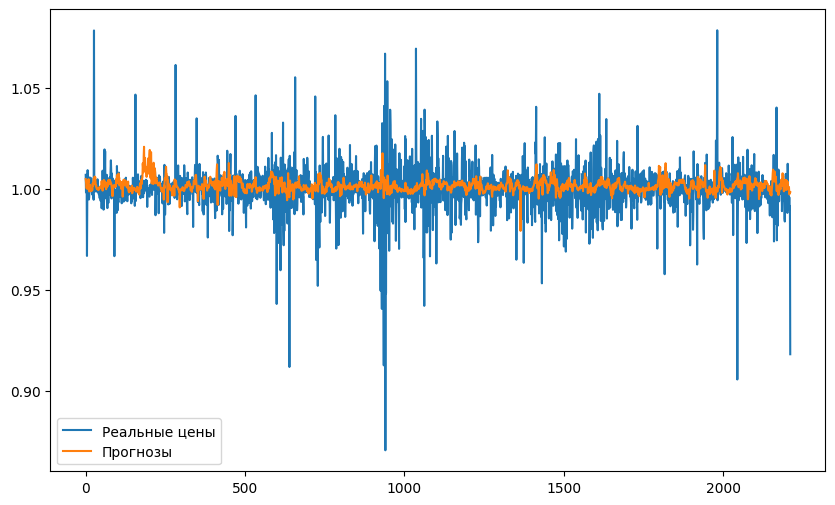

In [ ]:
create_dashboard(data, ensemble_predictions, y_test)

In [ ]:
# Создание стратегии для backtrader на основе Ensemble
class SimulationStrategyEnsemble(bt.Strategy):
    def __init__(self):
        self.prediction_index = 0  # Индекс для отслеживания текущего предсказания

    def next(self):
        if self.prediction_index < len(ensemble_predictions):
            prediction = ensemble_predictions[self.prediction_index]
            if prediction > 1:  # Если предсказание роста цены
                if not self.position:
                    self.buy()  # Открываем длинную позицию
            elif prediction < 1:  # Если предсказание падения цены
                if self.position:
                    self.sell()  # Закрываем позицию
            self.prediction_index += 1

In [ ]:
# Улучшенная торговая стратегия с управлением рисками
class EnhancedTradingStrategy(bt.Strategy):
    params = (
        ('risk_per_trade', 0.02),  # Риск 2% от капитала на сделку
        ('reward_ratio', 2),        # Соотношение прибыли к риску 2:1
        ('atr_multiplier', 1.5),   # Множитель для ATR стоп-лосса
        ('trailing_stop', True),    # Использовать трейлинг-стоп
        ('use_volatility_filter', True),  # Фильтр волатильности
        ('min_adx', 25),           # Минимальный ADX для трендовых сделок
    )

    def __init__(self):
        # Индикаторы для управления рисками
        self.atr = bt.indicators.ATR(self.data, period=14)
        self.adx = bt.indicators.AverageDirectionalMovementIndex(self.data, period=14)
        self.sma50 = bt.indicators.SMA(self.data.close, period=50)
        self.sma200 = bt.indicators.SMA(self.data.close, period=200)

        # Трейлинг-стоп
        self.trailing_stop_price = None
        self.prediction_index = 0
        self.ensemble_predictions = ensemble_predictions
        self.close_prices = Close_test

    def next(self):
        if self.prediction_index >= len(self.ensemble_predictions):
            return

        prediction = self.ensemble_predictions[self.prediction_index]
        current_close = self.close_prices[self.prediction_index]

        # Фильтр волатильности и тренда
        valid_trend = (self.adx[0] > self.p.min_adx) if self.p.use_volatility_filter else True
        golden_cross = (self.sma50[0] > self.sma200[0]) and (self.sma50[-1] <= self.sma200[-1])
        death_cross = (self.sma50[0] < self.sma200[0]) and (self.sma50[-1] >= self.sma200[-1])

        # Расчет размера позиции
        risk_amount = self.broker.getvalue() * self.p.risk_per_trade
        atr_stop = self.atr[0] * self.p.atr_multiplier
        position_size = risk_amount / atr_stop

        # Логика входа
        if not self.position:
            if prediction > 1.005 and valid_trend:  # Сигнал на покупку
                size = position_size / current_close
                self.buy(size=size)
                self.stop_price = current_close - atr_stop
                self.target_price = current_close + (atr_stop * self.p.reward_ratio)

            elif prediction < 0.995 and valid_trend:  # Сигнал на продажу
                size = position_size / current_close
                self.sell(size=size)
                self.stop_price = current_close + atr_stop
                self.target_price = current_close - (atr_stop * self.p.reward_ratio)

        # Управление открытой позицией
        else:
            # Обновление трейлинг-стопа
            if self.p.trailing_stop:
                if self.position.size > 0:  # Для длинной позиции
                    self.stop_price = max(self.stop_price, current_close - atr_stop)
                else:  # Для короткой позиции
                    self.stop_price = min(self.stop_price, current_close + atr_stop)

            # Проверка стоп-лосса и тейк-профита
            if (self.position.size > 0 and (current_close <= self.stop_price or current_close >= self.target_price)) or \
               (self.position.size < 0 and (current_close >= self.stop_price or current_close <= self.target_price)):
                self.close()

        self.prediction_index += 1

In [ ]:
# Тестирование ансамбля моделей
# Создание экземпляра Cerebro
cerebro = bt.Cerebro()

# Добавление стратегии
cerebro.addstrategy(SimulationStrategyEnsemble)
#cerebro.addstrategy(EnhancedTradingStrategy)

# Подготовка тестовых данных для backtrader
test_data = data.iloc[-len(X_test):]  # Выбираем тестовую часть данных
test_data = bt.feeds.PandasData(dataname=test_data)

# Добавление данных
cerebro.adddata(test_data)

# Добавление анализаторов
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe", timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# Установка начального капитала
cerebro.broker.set_cash(10000.0)
# Установка торговой комиссии
cerebro.broker.setcommission(commission=0.001)  # 0.1% комиссии

# Запуск симуляции с анализаторами
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
analysis = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Визуализация
cerebro.plot(style='candlestick', volume=False)

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10081.22


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

In [ ]:
# Вывод дополнительных характеристик
def print_trade_analysis(analyzer):
    print("\n--- Trade Analysis ---")
    print(f"Total Trades: {analyzer.total.total}")
    print(f"Total Closed Trades: {analyzer.total.closed}")
    print(f"Total Open Trades: {analyzer.total.open}")
    print(f"Total Won: {analyzer.won.total}")
    print(f"Total Lost: {analyzer.lost.total}")
    print(f"Win Rate: {analyzer.won.total / analyzer.total.closed * 100:.2f}%")
    print(f"Average Win: {analyzer.won.pnl.average:.2f}")
    print(f"Average Loss: {analyzer.lost.pnl.average:.2f}")
    #print(f"Profit Factor: {analyzer.pnl.net.profit_factor:.2f}")

def print_sharpe_ratio(analyzer):
    print("\n--- Sharpe Ratio ---")
    print(f"Sharpe Ratio: {analyzer.get('sharperatio', 'N/A'):.2f}")

def print_drawdown(analyzer):
    print("\n--- Drawdown ---")
    print(f"Max Drawdown: {analyzer.max.drawdown:.2f}%")
    print(f"Max Money Drawdown: {analyzer.max.moneydown:.2f}")

# Вывод результатов анализа
print_trade_analysis(analysis[0].analyzers.ta.get_analysis())
print_sharpe_ratio(analysis[0].analyzers.sharpe.get_analysis())
print_drawdown(analysis[0].analyzers.drawdown.get_analysis())
returns = analysis[0].analyzers.returns.get_analysis()
capital_history = analysis[0].analyzers.timereturn.get_analysis().items()

print(f"Общая доходность: {returns['rtot']:.2%}")

# Визуализация результатов
cerebro.plot()


--- Trade Analysis ---
Total Trades: 33
Total Closed Trades: 33
Total Open Trades: 0
Total Won: 20
Total Lost: 13
Win Rate: 60.61%
Average Win: 6.69
Average Loss: -4.05

--- Sharpe Ratio ---
Sharpe Ratio: -0.36

--- Drawdown ---
Max Drawdown: 0.33%
Max Money Drawdown: 32.82
Общая доходность: 0.81%


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

In [ ]:
# Добавление графика капитала в дашборд
def create_dashboard2(data, predictions, y_test, capital_history):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_test, label='Реальные цены')
    ax.plot(predictions, label='Прогнозы')
    ax.legend()
    st.pyplot(fig)

    st.write("### График изменения капитала")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(capital_history, label='Капитал')
    ax.set_xlabel('Время')
    ax.set_ylabel('Капитал')
    ax.legend()
    st.pyplot(fig)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

In [ ]:
create_dashboard2(data, ensemble_predictions, y_test, capital_history)

2025-03-25 14:58:07.007 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.013 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.030 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-25 14:58:07.433 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

ВЫВОДЫ:
1. Торговая стратегия на основе ансамбля генерирует небольшую прибыль
2. Линейная модель формирует лучший результат по сравнению с градиентным бустингом и ансамблем из них и нейронной сети на основе LSTM и GRU
